# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import sys
sys.path.append("../../..")
results_folder = "../../../reports/random_walks/"

In [2]:
model_param_grid = {
    "hidden_channels": [32, 64],
    "micro_aggregation": ["mean", "sum", "max"],
    "macro_aggregation": ["mean", "sum", "max"],
    "layer_connectivity": [None, "skipsum"],
    "L2_norm": [True, False],
    "pre_process_layers": [0, 1, 2],
    "msg_passing_layers": [2, 3, 4],
    "post_process_layers": [0, 1, 2],
    "normalize_output": [False, True],
    "jumping_knowledge": [True, False],
    "feature_dim": [16, 32, 64],
    "feature_type": ["random_xavier", "ones", "lsa_scaled"],
}

np.prod([len(val) for val in model_param_grid.values()])

69984

# Load data

In [3]:
keep = ['hidden_channels', 'conv_type', 'micro_aggregation','macro_aggregation', 'layer_connectivity', 'L2_norm','pre_process_layers', 'msg_passing_layers', 'post_process_layers','normalize_output', 'jumping_knowledge', 'feature_dim', 'feature_type',"mean_auc","std"]
walk_1_results = pd.read_csv(results_folder+"walk_3/random_walk_results.csv",index_col=0)[keep]
walk_2_results = pd.read_csv(results_folder+"walk_4/random_walk_results.csv",index_col=0)[keep]

walk_2_results["walk"] = 4
walk_1_results["walk"] = 3 
total_walk = pd.concat([walk_1_results,walk_2_results]).reset_index(names="walk_index")
total_walk["T"] = total_walk.walk.apply(lambda x: 0.1 if x == 3 else 0.2)


In [4]:
import pickle
step_history = total_walk.drop(columns=["mean_auc","std","walk_index","walk"]).astype({"L2_norm":bool,"normalize_output":bool,"jumping_knowledge":bool})
step_history.layer_connectivity = step_history.layer_connectivity.apply(lambda x: None if x != "skipsum" else x)
step_history = step_history.to_dict("index")
with open(results_folder+"walks_3_4_steps.pickle", 'wb') as handle:
    pickle.dump(step_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
total_walk.layer_connectivity = total_walk.layer_connectivity.apply(lambda x: "default" if x != "skipsum" else x)
total_walk.feature_type = total_walk.feature_type.apply(lambda x: "lsa" if x == "lsa_scaled" else x)

for col in ["L2_norm","jumping_knowledge","normalize_output"]:
    total_walk[col] = total_walk[col].astype(str)

total_walk

,walk_index,hidden_channels,conv_type,micro_aggregation,macro_aggregation,layer_connectivity,L2_norm,pre_process_layers,msg_passing_layers,post_process_layers,normalize_output,jumping_knowledge,feature_dim,feature_type,mean_auc,std,walk,T
0,0,32,SAGEConv,mean,mean,default,False,0,2,0,False,False,16,random_xavier,0.6106,0.029991,3,0.1
1,1,32,SAGEConv,mean,mean,default,False,2,2,0,False,False,16,random_xavier,0.6454,0.005352,3,0.1
2,2,32,SAGEConv,mean,mean,skipsum,False,2,2,0,False,False,16,random_xavier,0.6358,0.007859,3,0.1
3,3,32,SAGEConv,mean,mean,skipsum,False,1,2,0,False,False,16,random_xavier,0.6230,0.016829,3,0.1
4,4,32,SAGEConv,mean,mean,skipsum,False,1,4,0,False,False,16,random_xavier,0.6554,0.043975,3,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,34,64,SAGEConv,sum,max,skipsum,True,0,3,0,True,True,16,ones,0.7452,0.024301,4,0.2
59,35,64,SAGEConv,mean,max,skipsum,True,0,3,0,True,True,16,ones,0.6778,0.038499,4,0.2
60,36,64,SAGEConv,mean,max,skipsum,True,0,3,0,True,False,16,ones,0.6462,0.034879,4,0.2
61,37,64,SAGEConv,mean,max,skipsum,True,0,3,0,True,False,64,ones,0.6386,0.085596,4,0.2


Testeo que en cada paso esté cambiando un solo parámetro

In [6]:
diff = []
for i in range(len(total_walk)-1):
    diff.append(len(total_walk.drop(columns=["mean_auc","std","walk","walk_index"]).loc[i+1].compare(total_walk.drop(columns=["mean_auc","std","walk","walk_index"]).loc[i])))

sum([x != 1 for x in diff])

0

El que da diferente es diff = 0, es el primer paso de la segunda caminata que empieza desde donde dejó la otra

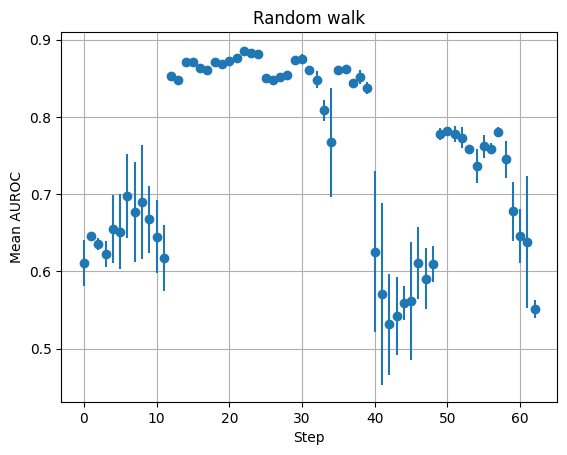

In [7]:
auc_chain = total_walk.mean_auc.values
std_chain = total_walk["std"].values
plt.errorbar(np.arange(len(auc_chain)), auc_chain, std_chain, fmt="o")
plt.title("Random walk")
plt.xticks(np.arange(0, len(auc_chain), 10))
plt.xlabel("Step")
plt.ylabel("Mean AUROC")
plt.grid(True)

In [6]:
total_walk.sort_values(by="mean_auc",ascending=False).iloc[0]

walk_index                   22
hidden_channels              64
conv_type              SAGEConv
micro_aggregation          mean
macro_aggregation          mean
layer_connectivity      skipsum
L2_norm                   False
pre_process_layers            0
msg_passing_layers            3
post_process_layers           2
normalize_output          False
jumping_knowledge         False
feature_dim                  32
feature_type                lsa
mean_auc                 0.8858
std                    0.002315
walk                          3
T                           0.1
Name: 22, dtype: object

In [21]:
fig = px.scatter(total_walk.astype({"T":str}),y="mean_auc",error_y="std",color="feature_type",labels={"mean_auc":"Mean AUROC","index":"Step"},width=800,height=400)
fig.show()

# Parametros

In [38]:
dims = {}
for dim in total_walk.columns:
    if dim not in ["walk_index","mean_auc","std","walk","conv_type"]:
        dims[dim] = total_walk[dim].value_counts().to_dict()

for param in total_walk.columns:
    if param not in ["walk_index","mean_auc","std","walk","conv_type"]:
        dims[param]
        fig = px.box(total_walk[[param,"mean_auc"]], x=param,y="mean_auc", width=800, height=400)
        for val,count in dims[param].items():
            fig.add_annotation(x = val,
                            y = total_walk[total_walk[param] == val]["mean_auc"].max(),
                            text = f"n counts: {count}",
                            yshift = 10,
                            showarrow = False
                        )
        fig.show()

In [30]:
parameter = "macro_aggregation"
# walk = 2

# df = total_walk[total_walk.feature_type == "lsa"]
df = total_walk
labels = {"mean_auc":"Mean AUROC", "index":"Step"}

dims = {}
for dim in df.columns:
    if dim not in ["walk_index","mean_auc","std","walk"]:
        dims[dim] = df[dim].value_counts().to_dict()
        labels[dim] = dim.replace("_"," ").capitalize()


fig1 = px.box(df[[parameter,"mean_auc"]], x=parameter,y="mean_auc", width=800, height=400,labels = labels)
for val,count in dims[parameter].items():
    fig1.add_annotation(x = val,
                    y = df[df[parameter] == val]["mean_auc"].max(),
                    text = f"n counts: {count}",
                    yshift = 10,
                    showarrow = False
                )
fig1.show()

fig2 = px.scatter(df.astype({parameter:str}),y="mean_auc",error_y="std",color=parameter,symbol="micro_aggregation",width=800, height=400,labels = labels, category_orders={parameter:["0","1","2","3","4"]})
fig2.show()

In [27]:
step = 35
display(total_walk.loc[step].compare(total_walk.loc[step-1]))
display(total_walk.loc[step].compare(total_walk.loc[step+1]))

,self,other
walk_index,11,10
post_process_layers,2,1
mean_auc,0.861,0.767
std,0.001673,0.070973


,self,other
walk_index,11,12
macro_aggregation,mean,sum
mean_auc,0.861,0.8618
std,0.001673,0.004118


In [30]:
parameter = "post_process_layers"
# walk = 2

# df = total_walk[total_walk.feature_type == "lsa"]
df = total_walk
labels = {"mean_auc":"Mean AUROC", "index":"Step"}

dims = {}
for dim in df.columns:
    if dim not in ["walk_index","mean_auc","std","walk"]:
        dims[dim] = df[dim].value_counts().to_dict()
        labels[dim] = dim.replace("_"," ").capitalize()


fig1 = px.box(df[[parameter,"mean_auc"]], x=parameter,y="mean_auc", width=800, height=400,labels = labels)
for val,count in dims[parameter].items():
    fig1.add_annotation(x = val,
                    y = df[df[parameter] == val]["mean_auc"].max(),
                    text = f"n counts: {count}",
                    yshift = 10,
                    showarrow = False
                )
fig1.show()

fig2 = px.scatter(df.astype({parameter:str}),y="mean_auc",error_y="std",color=parameter,symbol="micro_aggregation",width=800, height=400,labels = labels, category_orders={parameter:["0","1","2","3","4"]})
fig2.show()